In [31]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import numpy as np
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator - não é utilizado no PyTorchs


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:
def set_seed(seed):
    os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

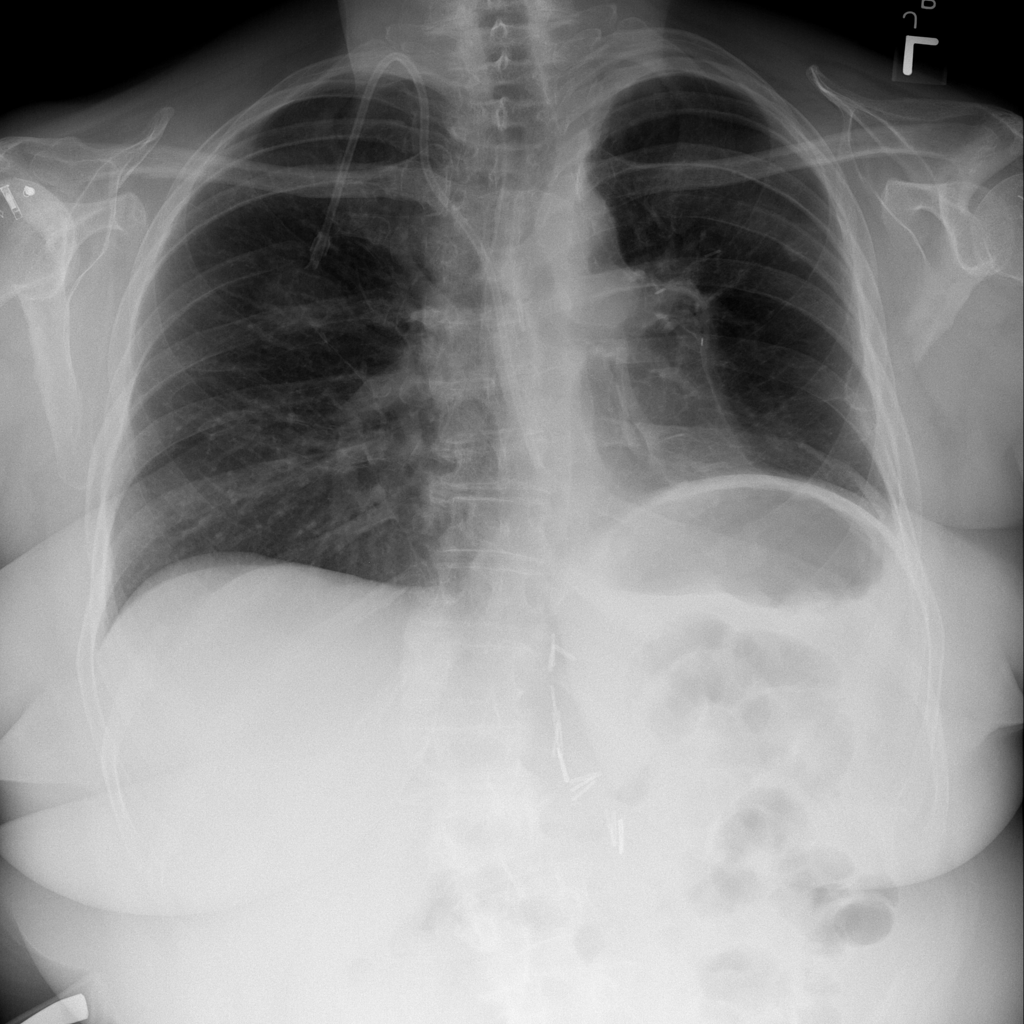

In [34]:
caminho_imagem = "D:/NIH Dataset/input/images_005/images/00009237_009.png"
imagem = Image.open(caminho_imagem)
display(imagem)

In [35]:
# Lendo o CSV
all_xray_df = pd.read_csv('D:/NIH Dataset/input/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].astype(int)

# Exibindo uma amostra
all_xray_df.sample(3)

Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,NaN,None
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,0.168,NaN,None
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,NaN,None


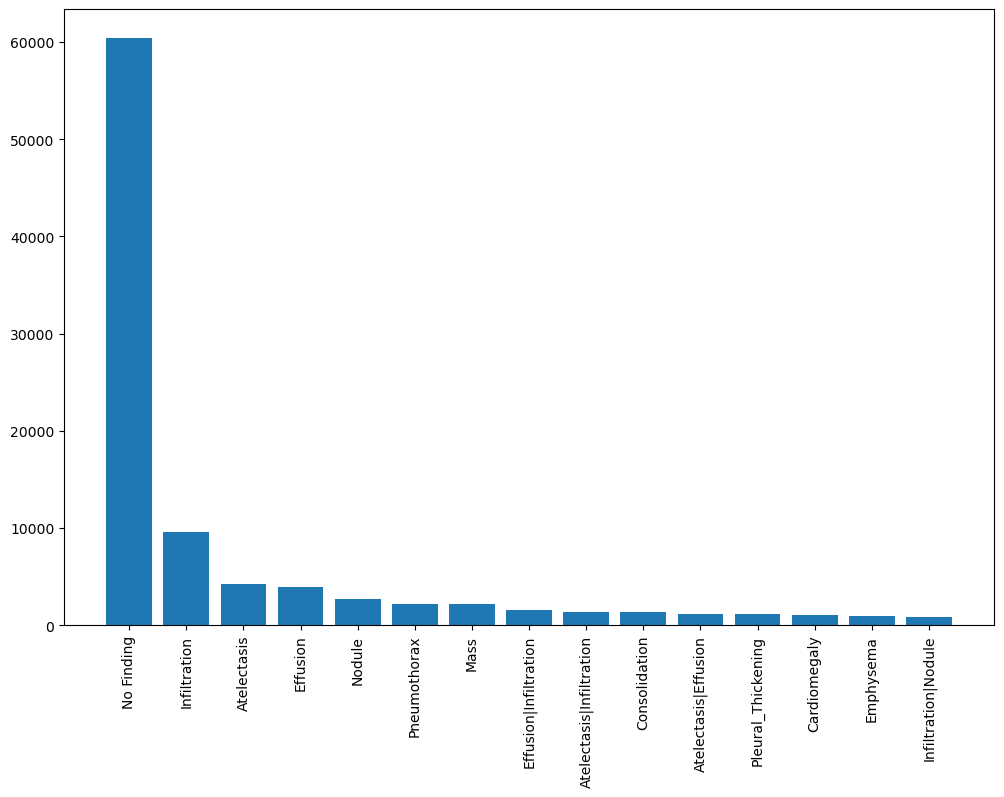

In [36]:
# Processando as Labels
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

Total de 'No Finding': 60361.0
Total de 'Has Finding': 51759.0
Tamanho total do dataset: 112120
            Image Index Finding Labels  No Finding  Has Finding
13396  00003489_000.png     No Finding         1.0          0.0
78570  00019271_053.png    Atelectasis         0.0          1.0
66807  00016508_048.png     No Finding         1.0          0.0
94578  00024320_000.png   Infiltration         0.0          1.0
14701  00003837_003.png     No Finding         1.0          0.0
Proporção original de 'No Finding': 0.538
Proporção original de 'Has Finding': 0.462
Contagem após reamostragem:
No Finding  Has Finding
1.0         0.0            20207
0.0         1.0            19793
Name: count, dtype: int64


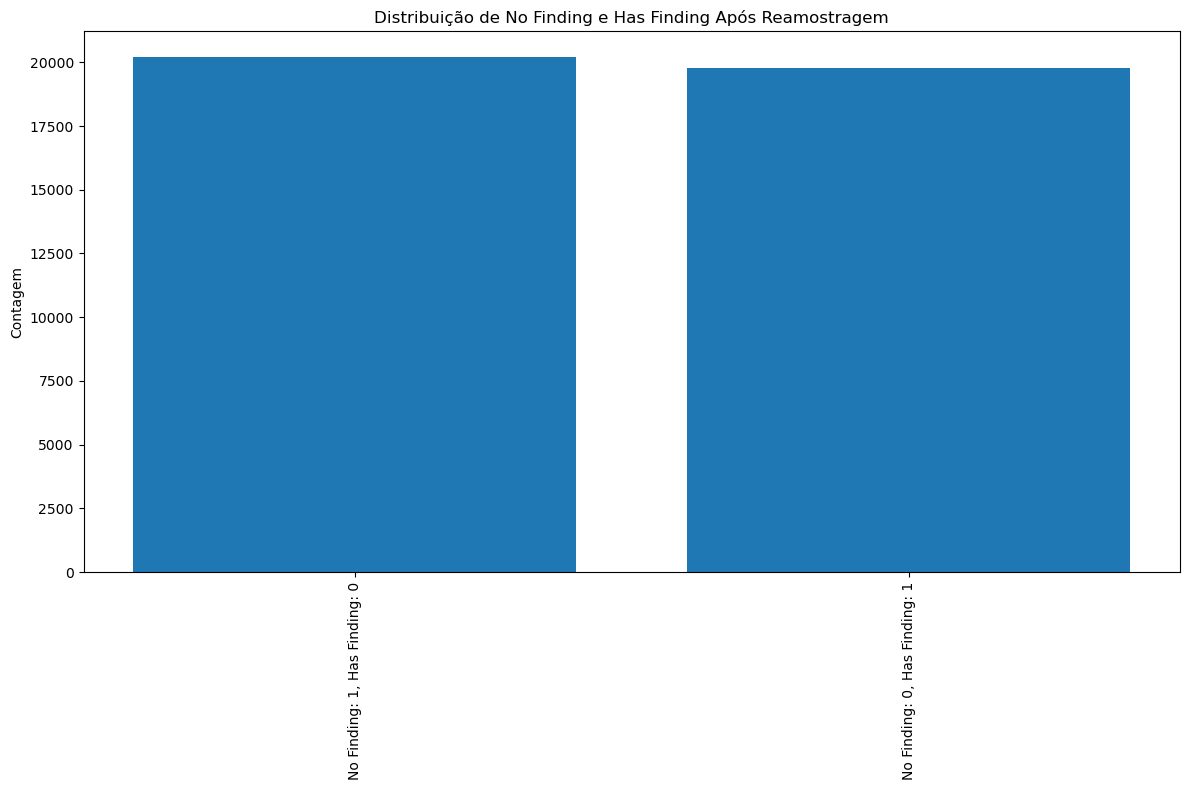

            Image Index Finding Labels  No Finding  Has Finding
5059   00001362_015.png    Atelectasis         0.0          1.0
7539   00001983_001.png     No Finding         1.0          0.0
37407  00009863_052.png     No Finding         1.0          0.0
73593  00018100_016.png     No Finding         1.0          0.0
14929  00003896_003.png     No Finding         1.0          0.0


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,No Finding,Has Finding
73386,00018055_004.png,No Finding,4,18055,63,M,AP,3056,2544,0.139000,0.139000,NaN,None,1.0,0.0
96617,00025454_006.png,Emphysema,6,25454,53,M,PA,2992,2991,0.143000,0.143000,NaN,None,0.0,1.0
9503,00002468_000.png,No Finding,0,2468,51,F,PA,3056,2544,0.139000,0.139000,NaN,None,1.0,0.0
7112,00001882_001.png,Infiltration,1,1882,26,M,PA,2048,2500,0.171000,0.171000,NaN,None,0.0,1.0
84632,00020829_000.png,No Finding,0,20829,59,M,AP,3056,2544,0.139000,0.139000,NaN,None,1.0,0.0
59996,00014809_018.png,No Finding,18,14809,53,M,PA,2500,2048,0.168000,0.168000,NaN,None,1.0,0.0
65592,00016191_004.png,Atelectasis|Infiltration,4,16191,65,M,PA,2500,2048,0.168000,0.168000,NaN,None,0.0,1.0
35970,00009488_003.png,No Finding,3,9488,58,F,PA,2048,2500,0.168000,0.168000,NaN,None,1.0,0.0
38672,00010092_049.png,No Finding,49,10092,51,F,PA,2500,2048,0.168000,0.168000,NaN,None,1.0,0.0
107933,00029192_000.png,No Finding,0,29192,59,F,PA,2021,2021,0.194311,0.194311,NaN,None,1.0,0.0


In [37]:
# Carregar os dados (assumindo que all_xray_df já está carregado)
# Se precisar carregar o CSV, descomente e ajuste o caminho:
# all_xray_df = pd.read_csv('caminho_do_seu_arquivo.csv')

# Processar as colunas binárias 'No Finding' e 'Has Finding'
all_xray_df['No Finding'] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if x == 'No Finding' else 0.0)
all_xray_df['Has Finding'] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if x != 'No Finding' and x != '' else 0.0)

# Verificar a contagem total de 'No Finding' e 'Has Finding'
print("Total de 'No Finding':", all_xray_df['No Finding'].sum())
print("Total de 'Has Finding':", all_xray_df['Has Finding'].sum())
print("Tamanho total do dataset:", len(all_xray_df))

# Exibir uma amostra do DataFrame com as colunas relevantes
print(all_xray_df[['Image Index', 'Finding Labels', 'No Finding', 'Has Finding']].sample(5))

# Calcular proporções originais
total_samples = len(all_xray_df)
no_finding_proportion = all_xray_df['No Finding'].sum() / total_samples
has_finding_proportion = all_xray_df['Has Finding'].sum() / total_samples
print(f"Proporção original de 'No Finding': {no_finding_proportion:.3f}")
print(f"Proporção original de 'Has Finding': {has_finding_proportion:.3f}")

# Ajustar os pesos para alcançar uma distribuição 50/50
# Queremos que a probabilidade de seleção seja ajustada para que, após a reamostragem,
# tenhamos aproximadamente 50% No Finding e 50% Has Finding
target_sample_size = 40000
target_no_finding = target_sample_size // 2  # 20.000
target_has_finding = target_sample_size // 2  # 20.000

# Calcular os pesos de amostragem para balancear as classes
# Peso = (número desejado / número atual) para cada classe
no_finding_weight = target_no_finding / all_xray_df['No Finding'].sum()
has_finding_weight = target_has_finding / all_xray_df['Has Finding'].sum()

# Atribuir pesos com base na classe
sample_weights = all_xray_df.apply(
    lambda row: no_finding_weight if row['No Finding'] == 1.0 else has_finding_weight,
    axis=1
).values
sample_weights /= sample_weights.sum()  # Normalizar os pesos

# Reamostragem para 40.000 amostras
all_xray_df_resampled = all_xray_df.sample(n=target_sample_size, weights=sample_weights, random_state=42)

# Contar a frequência de 'No Finding' e 'Has Finding' após reamostragem
label_counts = all_xray_df_resampled[['No Finding', 'Has Finding']].value_counts()
print("Contagem após reamostragem:")
print(label_counts)

# Plotar o gráfico
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
ax1.set_xticklabels([f"No Finding: {int(k[0])}, Has Finding: {int(k[1])}" for k in label_counts.index], rotation=90)
ax1.set_title("Distribuição de No Finding e Has Finding Após Reamostragem")
ax1.set_ylabel("Contagem")
plt.tight_layout()
plt.show()

# Exibir uma amostra do DataFrame reamostrado
print(all_xray_df_resampled[['Image Index', 'Finding Labels', 'No Finding', 'Has Finding']].sample(5))

all_xray_df_resampled.sample(20)

Contagem após reamostragem:
No Finding  Has Finding
1.0         0.0            20207
0.0         1.0            19793
Name: count, dtype: int64


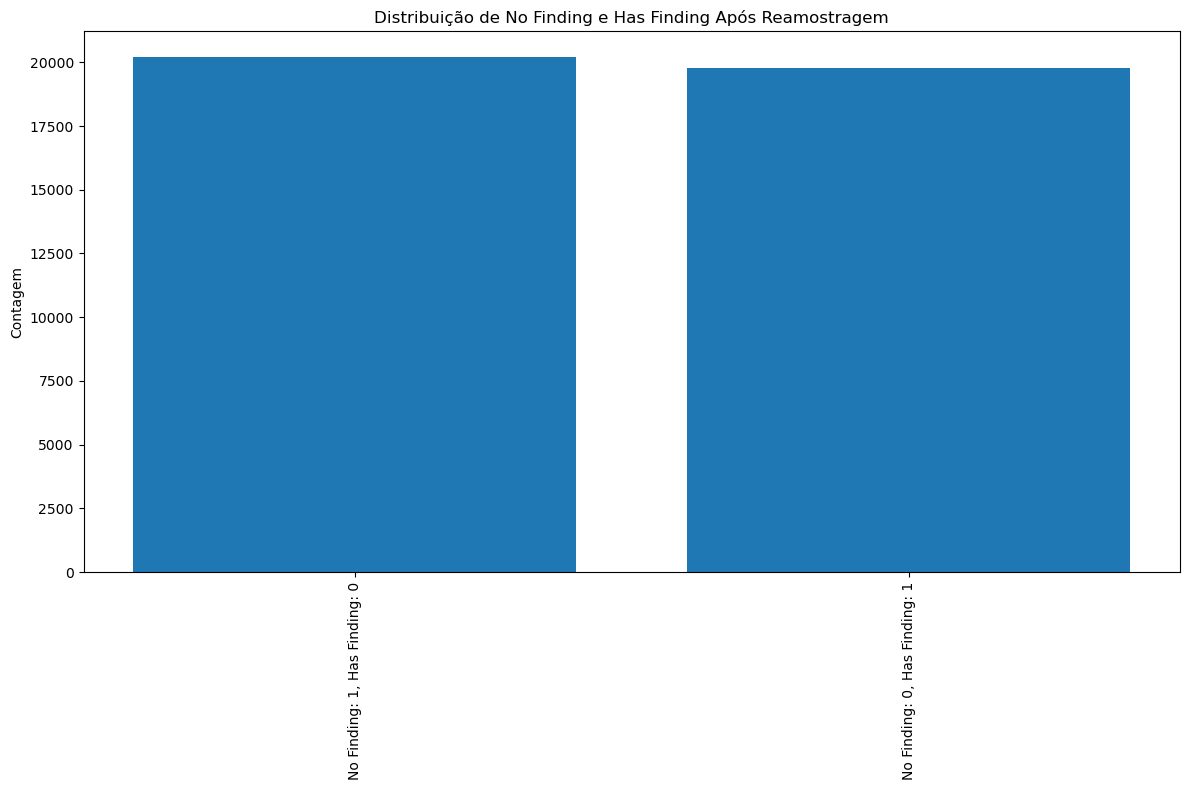


Contagem no conjunto de treino:
No Finding  Has Finding
1.0         0.0            14145
0.0         1.0            13855
Name: count, dtype: int64

Contagem no conjunto de validação:
No Finding  Has Finding
1.0         0.0            3031
0.0         1.0            2969
Name: count, dtype: int64

Contagem no conjunto de teste:
No Finding  Has Finding
1.0         0.0            3031
0.0         1.0            2969
Name: count, dtype: int64


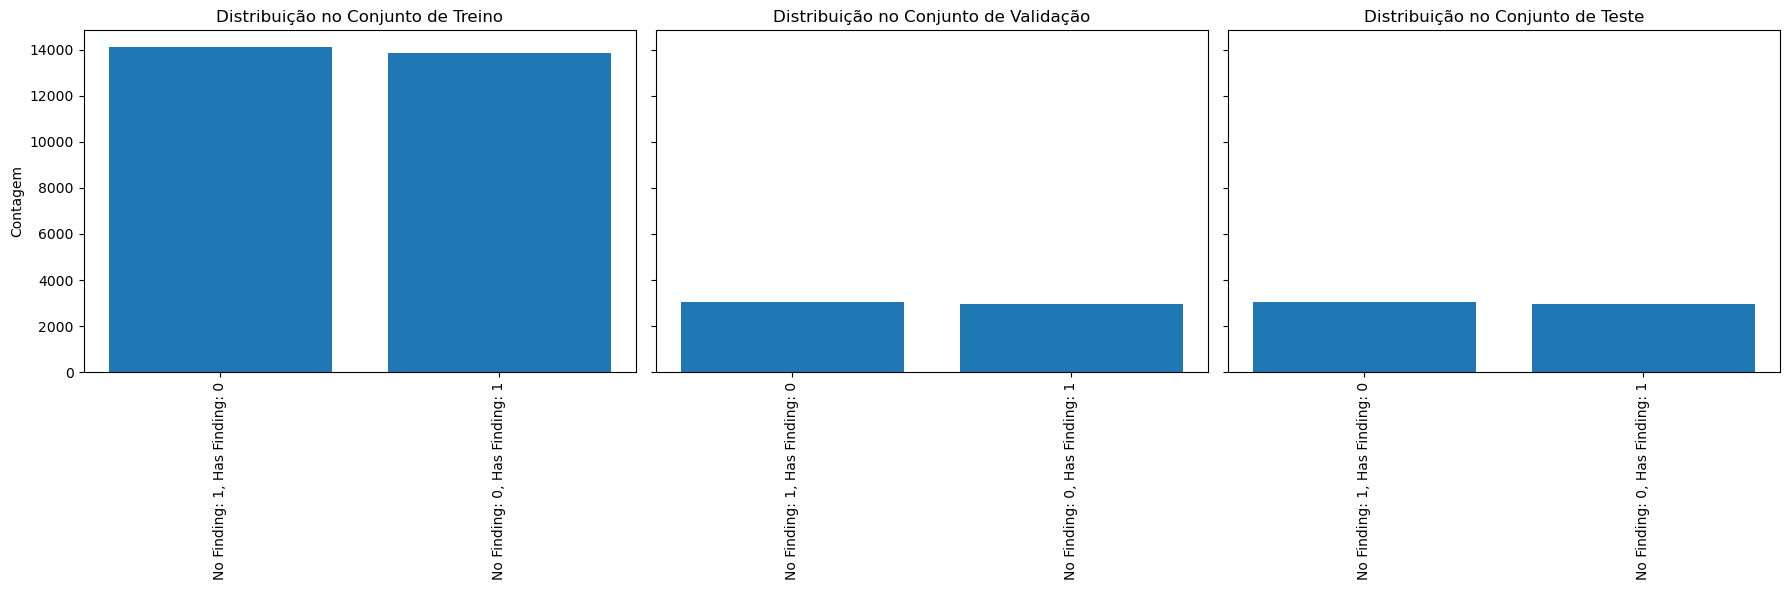


Amostra do conjunto de treino:
            Image Index         Finding Labels  No Finding  Has Finding
26449  00014427_009.png             No Finding         1.0          0.0
7267   00016692_000.png             No Finding         1.0          0.0
9009   00025839_016.png  Effusion|Infiltration         0.0          1.0
832    00007825_003.png             No Finding         1.0          0.0
7994   00013176_003.png                  Edema         0.0          1.0

Amostra do conjunto de validação:
           Image Index                                     Finding Labels  \
777   00028765_027.png  Consolidation|Effusion|Infiltration|Pleural_Th...   
3937  00021381_010.png                                         No Finding   
5992  00017709_009.png                  Atelectasis|Effusion|Infiltration   
4870  00007239_009.png                                         No Finding   
4373  00019725_000.png                                         No Finding   

      No Finding  Has Finding  
777   

In [38]:
# Após a reamostragem, temos all_xray_df_resampled com 40.000 amostras (50/50)

# Contar a frequência de 'No Finding' e 'Has Finding' após reamostragem
label_counts = all_xray_df_resampled[['No Finding', 'Has Finding']].value_counts()
print("Contagem após reamostragem:")
print(label_counts)

# Plotar o gráfico da distribuição após reamostragem
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
ax1.set_xticklabels([f"No Finding: {int(k[0])}, Has Finding: {int(k[1])}" for k in label_counts.index], rotation=90)
ax1.set_title("Distribuição de No Finding e Has Finding Após Reamostragem")
ax1.set_ylabel("Contagem")
plt.tight_layout()
plt.show()

# Separar o conjunto reamostrado em treino, validação e teste (70/15/15) usando train_test_split
# Criar uma coluna de estratificação com base em 'No Finding' (ou 'Has Finding', já que são mutuamente exclusivos)
# Como 'No Finding' e 'Has Finding' são binários e complementares, podemos usar apenas 'No Finding' para estratificar
stratify_col = all_xray_df_resampled['No Finding']

# Primeiro, separar o conjunto de treino (70%) e o restante (30%)
train_df, temp_df = train_test_split(
    all_xray_df_resampled,
    test_size=0.3,  # 30% para validação + teste
    stratify=stratify_col,
    random_state=42
)

# Agora, dividir o restante (temp_df) em validação (15%) e teste (15%)
# Como temp_df tem 30% do total (12.000 amostras), queremos 50% disso para validação e 50% para teste
stratify_col_temp = temp_df['No Finding']
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # 50% de 12.000 = 6.000 para validação e 6.000 para teste
    stratify=stratify_col_temp,
    random_state=42
)

# Resetar os índices dos conjuntos finais
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Verificar as contagens em cada subconjunto
print("\nContagem no conjunto de treino:")
print(train_df[['No Finding', 'Has Finding']].value_counts())
print("\nContagem no conjunto de validação:")
print(valid_df[['No Finding', 'Has Finding']].value_counts())
print("\nContagem no conjunto de teste:")
print(test_df[['No Finding', 'Has Finding']].value_counts())

# Plotar gráficos para cada subconjunto
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Treino
train_counts = train_df[['No Finding', 'Has Finding']].value_counts()
ax1.bar(np.arange(len(train_counts)) + 0.5, train_counts)
ax1.set_xticks(np.arange(len(train_counts)) + 0.5)
ax1.set_xticklabels([f"No Finding: {int(k[0])}, Has Finding: {int(k[1])}" for k in train_counts.index], rotation=90)
ax1.set_title("Distribuição no Conjunto de Treino")
ax1.set_ylabel("Contagem")

# Validação
valid_counts = valid_df[['No Finding', 'Has Finding']].value_counts()
ax2.bar(np.arange(len(valid_counts)) + 0.5, valid_counts)
ax2.set_xticks(np.arange(len(valid_counts)) + 0.5)
ax2.set_xticklabels([f"No Finding: {int(k[0])}, Has Finding: {int(k[1])}" for k in valid_counts.index], rotation=90)
ax2.set_title("Distribuição no Conjunto de Validação")

# Teste
test_counts = test_df[['No Finding', 'Has Finding']].value_counts()
ax3.bar(np.arange(len(test_counts)) + 0.5, test_counts)
ax3.set_xticks(np.arange(len(test_counts)) + 0.5)
ax3.set_xticklabels([f"No Finding: {int(k[0])}, Has Finding: {int(k[1])}" for k in test_counts.index], rotation=90)
ax3.set_title("Distribuição no Conjunto de Teste")

plt.tight_layout()
plt.show()

# Exibir uma amostra de cada subconjunto
print("\nAmostra do conjunto de treino:")
print(train_df[['Image Index', 'Finding Labels', 'No Finding', 'Has Finding']].sample(5))
print("\nAmostra do conjunto de validação:")
print(valid_df[['Image Index', 'Finding Labels', 'No Finding', 'Has Finding']].sample(5))
print("\nAmostra do conjunto de teste:")
print(test_df[['Image Index', 'Finding Labels', 'No Finding', 'Has Finding']].sample(5))

In [39]:
# Verificar o DataFrame reamostrado
print(f"Tamanho do DataFrame reamostrado: {len(all_xray_df_resampled)}")
print("Amostra do DataFrame reamostrado:")
print(all_xray_df_resampled[['Image Index', 'No Finding', 'Has Finding']].head())

# Separar o conjunto reamostrado em treino, validação e teste (70/15/15)
stratify_col = all_xray_df_resampled['No Finding']
train_df, temp_df = train_test_split(
    all_xray_df_resampled,
    test_size=0.3,
    stratify=stratify_col,
    random_state=42
)
stratify_col_temp = temp_df['No Finding']
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=stratify_col_temp,
    random_state=42
)

# Resetar os índices dos conjuntos finais
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Verificar os DataFrames após a divisão
print(f"Tamanho do conjunto de treino após divisão: {len(train_df)}")
print(f"Tamanho do conjunto de validação após divisão: {len(valid_df)}")
print(f"Tamanho do conjunto de teste após divisão: {len(test_df)}")

print("Amostra da coluna 'Image Index' no conjunto de treino:")
print(train_df['Image Index'].head())
print("Amostra da coluna 'Image Index' no conjunto de validação:")
print(valid_df['Image Index'].head())
print("Amostra da coluna 'Image Index' no conjunto de teste:")
print(test_df['Image Index'].head())

# Caminho base para o diretório que contém as subpastas
base_dataset_path = "D:/NIH Dataset/input"

# Listar todas as subpastas que contêm imagens (ex.: images_001, images_002, etc.)
image_dirs = glob(os.path.join(base_dataset_path, "images_*"))
print(f"Subpastas encontradas: {image_dirs}")

# Criar um dicionário para mapear o nome do arquivo ao caminho completo
image_path_dict = {}
for image_dir in image_dirs:
    image_subdir = os.path.join(image_dir, "images")
    if not os.path.exists(image_subdir):
        print(f"Subpasta não encontrada: {image_subdir}")
        continue
    image_files = glob(os.path.join(image_subdir, "*.png"))
    print(f"Imagens encontradas em {image_subdir}: {len(image_files)}")
    for image_file in image_files:
        image_name = os.path.basename(image_file).lower()  # Normalizar para minúsculas
        image_path_dict[image_name] = image_file

# Verificar o dicionário
print(f"Total de imagens no dicionário: {len(image_path_dict)}")
print("Amostra de chaves no dicionário (nomes dos arquivos):")
print(list(image_path_dict.keys())[:5])

# Normalizar os nomes no DataFrame
train_df['Image Index'] = train_df['Image Index'].str.lower()
valid_df['Image Index'] = valid_df['Image Index'].str.lower()
test_df['Image Index'] = test_df['Image Index'].str.lower()

# Adicionar a coluna 'image_path' aos DataFrames
train_df['image_path'] = train_df['Image Index'].map(image_path_dict)
valid_df['image_path'] = valid_df['Image Index'].map(image_path_dict)
test_df['image_path'] = test_df['Image Index'].map(image_path_dict)

# Verificar algumas associações
print("Amostra de 'Image Index' e 'image_path' no conjunto de treino:")
print(train_df[['Image Index', 'image_path']].head())
print("Amostra de 'Image Index' e 'image_path' no conjunto de validação:")
print(valid_df[['Image Index', 'image_path']].head())
print("Amostra de 'Image Index' e 'image_path' no conjunto de teste:")
print(test_df[['Image Index', 'image_path']].head())

# Verificar se há imagens não encontradas
missing_train = train_df['image_path'].isna().sum()
missing_valid = valid_df['image_path'].isna().sum()
missing_test = test_df['image_path'].isna().sum()
print(f"Imagens não encontradas no conjunto de treino: {missing_train}")
print(f"Imagens não encontradas no conjunto de validação: {missing_valid}")
print(f"Imagens não encontradas no conjunto de teste: {missing_test}")

# Opcional: Exibir algumas linhas com caminhos ausentes para depuração
if missing_train > 0:
    print("Amostra de imagens não encontradas no conjunto de treino:")
    print(train_df[train_df['image_path'].isna()][['Image Index']].head())
if missing_valid > 0:
    print("Amostra de imagens não encontradas no conjunto de validação:")
    print(valid_df[valid_df['image_path'].isna()][['Image Index']].head())
if missing_test > 0:
    print("Amostra de imagens não encontradas no conjunto de teste:")
    print(test_df[test_df['image_path'].isna()][['Image Index']].head())

# Opcional: Remover linhas com imagens não encontradas
train_df = train_df.dropna(subset=['image_path']).reset_index(drop=True)
valid_df = valid_df.dropna(subset=['image_path']).reset_index(drop=True)
test_df = test_df.dropna(subset=['image_path']).reset_index(drop=True)

# Verificar o número de imagens encontradas
print(f"Imagens encontradas no conjunto de treino: {len(train_df)}")
print(f"Imagens encontradas no conjunto de validação: {len(valid_df)}")
print(f"Imagens encontradas no conjunto de teste: {len(test_df)}")

train_df.sample(5)
valid_df.sample(5)
test_df.sample(5)

Tamanho do DataFrame reamostrado: 40000
Amostra do DataFrame reamostrado:
             Image Index  No Finding  Has Finding
42235   00010864_015.png         1.0          0.0
106616  00028765_014.png         0.0          1.0
82167   00020213_027.png         1.0          0.0
67334   00016623_001.png         0.0          1.0
17620   00004750_002.png         1.0          0.0
Tamanho do conjunto de treino após divisão: 28000
Tamanho do conjunto de validação após divisão: 6000
Tamanho do conjunto de teste após divisão: 6000
Amostra da coluna 'Image Index' no conjunto de treino:
0    00029044_000.png
1    00013088_001.png
2    00026261_006.png
3    00006336_006.png
4    00008818_000.png
Name: Image Index, dtype: object
Amostra da coluna 'Image Index' no conjunto de validação:
0    00026889_001.png
1    00004407_000.png
2    00029901_004.png
3    00002550_000.png
4    00009507_022.png
Name: Image Index, dtype: object
Amostra da coluna 'Image Index' no conjunto de teste:
0    00019895_000.png
1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,No Finding,Has Finding,image_path
1805,00016796_005.png,Pneumothorax,5,16796,64,F,PA,2992,2991,0.143,0.143,NaN,None,0.0,1.0,D:/NIH Dataset/input\images_008\images\0001679...
5831,00017138_027.png,Atelectasis|Effusion,27,17138,24,M,AP,2500,2048,0.168,0.168,NaN,None,0.0,1.0,D:/NIH Dataset/input\images_008\images\0001713...
1913,00024195_000.png,No Finding,0,24195,30,M,PA,2500,2048,0.168,0.168,NaN,None,1.0,0.0,D:/NIH Dataset/input\images_010\images\0002419...
4926,00007557_012.png,Effusion|Pneumothorax,12,7557,60,M,AP,2500,2048,0.168,0.168,NaN,None,0.0,1.0,D:/NIH Dataset/input\images_004\images\0000755...
1755,00008023_001.png,No Finding,1,8023,29,M,PA,2500,2048,0.168,0.168,NaN,None,1.0,0.0,D:/NIH Dataset/input\images_004\images\0000802...


In [40]:
# Definir a classe de dataset personalizada
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame com colunas 'image_path' e 'Has Finding'.
            transform (callable, optional): Transformações a serem aplicadas nas imagens.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Carregar a imagem
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')  # Converter para RGB (3 canais), necessário para ResNet50

        # Carregar o rótulo (Has Finding: 0 ou 1)
        label = self.dataframe.iloc[idx]['Has Finding']
        label = np.array(label, dtype=np.float32)  # Converter para float32 para compatibilidade com PyTorch

        # Aplicar transformações, se fornecidas
        if self.transform:
            image = self.transform(image)

        return image, label

# Definir transformações para treino, validação e teste
# Transformações para o conjunto de treino (com aumentação de dados)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar para 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal com 50% de chance
    transforms.RandomRotation(degrees=15),  # Rotação aleatória de até 15 graus
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Ajuste de brilho e contraste
    transforms.ToTensor(),  # Converter para tensor (normaliza para [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalizar com base no ImageNet
                        std=[0.229, 0.224, 0.225])
])

# Transformações para validação e teste (sem aumentação, apenas pré-processamento)
valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar para 224x224
    transforms.ToTensor(),  # Converter para tensor (normaliza para [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalizar com base no ImageNet
                        std=[0.229, 0.224, 0.225])
])

# Criar datasets para treino, validação e teste
train_dataset = ChestXRayDataset(dataframe=train_df, transform=train_transforms)
valid_dataset = ChestXRayDataset(dataframe=valid_df, transform=valid_test_transforms)
test_dataset = ChestXRayDataset(dataframe=test_df, transform=valid_test_transforms)

# Definir parâmetros do DataLoader
batch_size = 32
num_workers = 0  # Desativar trabalhadores paralelos para evitar problemas no Windows
shuffle_train = True  # Embaralhar o conjunto de treino
shuffle_valid_test = False  # Não embaralhar validação e teste

# Criar DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle_train,
    num_workers=num_workers,
    pin_memory=True  # Acelera a transferência para GPU, se disponível
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=shuffle_valid_test,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=shuffle_valid_test,
    num_workers=num_workers,
    pin_memory=True
)

# Verificar os tamanhos dos DataLoaders
print(f"Número de batches no conjunto de treino: {len(train_loader)}")
print(f"Número de batches no conjunto de validação: {len(valid_loader)}")
print(f"Número de batches no conjunto de teste: {len(test_loader)}")

# Testar o carregamento de um batch
images, labels = next(iter(train_loader))
print(f"Shape do batch de imagens: {images.shape}")  # Esperado: [batch_size, 3, 224, 224]
print(f"Shape do batch de rótulos: {labels.shape}")  # Esperado: [batch_size]
print(f"Exemplo de rótulos: {labels[:5]}")

Número de batches no conjunto de treino: 875
Número de batches no conjunto de validação: 188
Número de batches no conjunto de teste: 188
Shape do batch de imagens: torch.Size([32, 3, 224, 224])
Shape do batch de rótulos: torch.Size([32])
Exemplo de rótulos: tensor([1., 1., 1., 1., 1.])


In [41]:
# Definir a arquitetura da CNN
class ChestXRayCNN(nn.Module):
    def __init__(self):
        super(ChestXRayCNN, self).__init__()
        
        # Bloco 1: 3 -> 32 filtros
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # [32, 224, 224]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # [32, 224, 224]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # [32, 112, 112]
        )
        
        # Bloco 2: 32 -> 64 filtros
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # [64, 56, 56]
        )
        
        # Bloco 3: 64 -> 128 filtros
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # [128, 28, 28]
        )
        
        # Bloco 4: 128 -> 256 filtros
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),  # [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # [256, 14, 14]
        )
        
        # Camadas totalmente conectadas
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # [256 * 14 * 14 = 50.176]
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Saída para classificação binária
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.fc_layers(x)
        return x  # Retorna logits (antes da sigmoide)

# Instanciar o modelo e movê-lo para o dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChestXRayCNN().to(device)
print(model)

# Testar o modelo com um batch de dados
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
print(f"Shape da saída do modelo: {outputs.shape}")  # Esperado: [batch_size, 1]

ChestXRayCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64,